# Part one is done in a different notebook called phase1.ipynb

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from copy import deepcopy
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

# Dataloader

In [2]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = np.zeros((labels.size, n_classes))
        onehot_vectors[np.arange(labels.size),labels] = 1
        return onehot_vectors
    
    def __shuffle_dataset(self):
        rng_state = np.random.get_state()
        np.random.shuffle(self.__data)
        np.random.set_state(rng_state)
        np.random.shuffle(self.__onehot_labels)
    
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [3]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        relu_value = deepcopy(matrix)
        relu_value[relu_value <= 0] = 0
        return relu_value

    def derivative(self, matrix):
        relu_derivative = deepcopy(matrix)
        relu_derivative[relu_derivative > 0] = 1
        relu_derivative[relu_derivative <= 0] = 0
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = np.matrix(np.maximum(matrix, matrix * self.negative_slope), dtype=float)
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = np.matrix(matrix, dtype=float)
        leacky_relu_derivative[leacky_relu_derivative >= 0] = 1
        leacky_relu_derivative[leacky_relu_derivative < 0] = -self.negative_slope
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        sigmoid_value = np.matrix(1/(1 + np.exp(-matrix)), dtype=float)
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_value = self.__val(matrix)
        sigmoid_derivative = np.matrix(np.multiply(sigmoid_value,(1 - sigmoid_value)), dtype=float)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        matrix = matrix - np.max(matrix, axis=1)
        softmax_value = np.matrix(np.exp(matrix) / np.sum(np.exp(matrix), axis=1), dtype=float)
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        positive_exponent = np.exp(matrix)
        negative_exponent = np.exp(-matrix)
        tanh_value = np.matrix((positive_exponent - negative_exponent) / (positive_exponent + negative_exponent), dtype=float)
        return tanh_value

    def derivative(self, matrix):
        tanh_derivative = np.matrix(1 - np.power(self.__val(matrix), 2), dtype=float)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [5]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        cross_entropy_value = np.multiply(-expected_val, np.log(np.clip(softmax(true_val), 1e-50, 1 - 1e-50))).sum(axis = 1) 
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        return softmax(true_val + 1e-50) - expected_val
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [6]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR, CLIP = 0, 0.05, 0., 1., 10
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        assert np.size(self.__weight,1) == np.size(self.__bias)
        self.__last_input = layer_input
        self.__last_activation_input = layer_input.dot(self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = np.squeeze(self.__activation.derivative(self.__last_activation_input))
        
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        
        backprop_tensor = np.squeeze(backprop_tensor)

        b2 = np.multiply(backprop_tensor, self.__last_activation_derivative)

        dw = self.__last_input.T.dot(b2)

        db = np.sum(b2, axis=0)

        new_backprop_tensor = b2.dot(self.__weight.T)
        self.__bias = self.__bias - (lr * db)
        self.__weight = self.__weight - (lr * dw)
        
        
        return new_backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low, high, dim1 * dim2)
        weights = weights.reshape(dim1, dim2)
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.random.normal(mean, var, dim1 * dim2)
        weights = weights.reshape(dim1, dim2)
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [9]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Sigmoid(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        softmax = Softmax()
        network_output = deepcopy(network_input)
        for i in range(len(self.__layers_list)):
            network_output = self.__layers_list[i].forward(network_output)
            network_output = np.squeeze(network_output)
        network_output = softmax(network_output)
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        result = deepcopy(x_batch)
        softmax = Softmax()
        for i in range(len(self.__layers_list)):
            result = self.__layers_list[i].forward(result)
        loss = self.__loss(result, y_batch)
        self.__update_weights(result, y_batch)
        result = softmax(result)
        
        batch_accuracy = self.__compute_accuracy(result, y_batch)
        batch_average_loss = np.mean(loss)
    
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        result = deepcopy(x_batch)
        softmax = Softmax()
        for i in range(len(self.__layers_list)):
            result = self.__layers_list[i].forward(result)
        loss = self.__loss(result, y_batch)
        result = softmax(result)
        
        batch_accuracy = self.__compute_accuracy(result, y_batch)
        batch_average_loss = np.mean(loss)
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        labels = np.argmax(outputs, axis=1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        labels_output = self.__get_labels(output)
        labels_expected = self.__get_labels(expected_output)
        count_uncorrect = np.count_nonzero(labels_expected - labels_output)
        accuracy = (len(labels_expected) - count_uncorrect) / len(labels_expected)
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        back_prop_tensor = self.__loss.derivative(output, y_train)
        for layer in self.__layers_list[::-1]:
            back_prop_tensor = layer.update_weights(back_prop_tensor, self.__lr)
        return

# Training Sample Code

In [32]:
X_train = pd.read_csv("./Dataset/dataset/train_images.csv")
X_test = pd.read_csv("./Dataset/dataset/test_images.csv")
y_train = pd.read_csv("./Dataset/dataset/train_labels.csv")
y_test = pd.read_csv("./Dataset/dataset/test_labels.csv")

In [33]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((60000, 785), (60000, 2), (15000, 785), (15000, 2))


In [34]:
y_train = y_train.drop(columns=['Unnamed: 0'], axis=1)
y_test = y_test.drop(columns=['Unnamed: 0'], axis=1)
X_train = X_train.drop(columns=['Unnamed: 0'], axis=1)
X_test = X_test.drop(columns=['Unnamed: 0'], axis=1)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

temp = X_test.to_numpy()
X_test = temp
temp = X_train.to_numpy()
X_train = temp

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print(type(X_train), type(X_test), type(y_train), type(y_test))

((60000, 784), (60000, 1), (15000, 784), (15000, 1))
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [35]:
y_test = y_test.reshape(len(y_test))
y_train = y_train.reshape(len(y_train))

print(y_test.shape, y_train.shape)

(15000,) (60000,)


In [36]:
X_train = X_train / 255
X_test = X_test / 255

# Phase 3

In [15]:
trainloader = Dataloader(X_train, y_train, n_classes=20, batch_size=64)
testloader = Dataloader(X_test, y_test, n_classes=20, batch_size=64)

In [16]:
INPUT_SHAPE = X_train.shape[1]
LEARNING_RATE = 1e-3
EPOCHS = 20

In [24]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)

In [25]:
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.12936433901918976	Average Loss: 2.6833568682570212
	Test: Average Accuracy: 0.178125	Average Loss: 2.496684346265347
Epoch 2:
	Train: Average Accuracy: 0.3386693763326226	Average Loss: 2.029533977150357
	Test: Average Accuracy: 0.43107269503546103	Average Loss: 1.869994682048095
Epoch 3:
	Train: Average Accuracy: 0.5991138059701493	Average Loss: 1.3465136569411151
	Test: Average Accuracy: 0.5529033687943263	Average Loss: 1.5409856162658344
Epoch 4:
	Train: Average Accuracy: 0.695262526652452	Average Loss: 1.0553869456164797
	Test: Average Accuracy: 0.6360372340425532	Average Loss: 1.3032039797026085
Epoch 5:
	Train: Average Accuracy: 0.7641424573560768	Average Loss: 0.8403837845073577
	Test: Average Accuracy: 0.6847960992907801	Average Loss: 1.1317762859632907
Epoch 6:
	Train: Average Accuracy: 0.8094682835820896	Average Loss: 0.6847780944550427
	Test: Average Accuracy: 0.720921985815603	Average Loss: 1.006930493193504
Epoch 7:
	Train: Average Accur

## Learning rate effect

### Effect of low learning rate
We see the model doesn't evolve as fast and reaches less accuracy in the same amount of epochs also the model might be less general due to over fitting that comes with low LR and the test gets worst accuracy

In [26]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=1e-4)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.056919642857142856	Average Loss: 2.9497576895331212
	Test: Average Accuracy: 0.05642730496453901	Average Loss: 2.94486745680227
Epoch 2:
	Train: Average Accuracy: 0.06421575159914712	Average Loss: 2.9251157685923204
	Test: Average Accuracy: 0.07854609929078016	Average Loss: 2.9271291543551476
Epoch 3:
	Train: Average Accuracy: 0.08207289445628999	Average Loss: 2.9035127078444134
	Test: Average Accuracy: 0.10252659574468086	Average Loss: 2.9075220528882766
Epoch 4:
	Train: Average Accuracy: 0.12058568763326226	Average Loss: 2.858659138771639
	Test: Average Accuracy: 0.16006205673758864	Average Loss: 2.803919330594154
Epoch 5:
	Train: Average Accuracy: 0.1965118603411514	Average Loss: 2.532341808483478
	Test: Average Accuracy: 0.1892730496453901	Average Loss: 2.4895827305414002
Epoch 6:
	Train: Average Accuracy: 0.25631329957356075	Average Loss: 2.3180644282476752
	Test: Average Accuracy: 0.25851063829787235	Average Loss: 2.361201259421339
Epoch 7:
	T

### Effect of high learning rate
This time due to big step sizes the model over shoots from were it should be and never really finds the optimal weights.<br>
as we see below the model doesn't actualy get trained at all and the learning starts to feel like a random walk of the weights

In [42]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=1e-2)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.05563699360341151	Average Loss: 2.9850127862554103
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.950337314937101
Epoch 2:
	Train: Average Accuracy: 0.05553704690831557	Average Loss: 2.9516135413028857
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.950334727651935
Epoch 3:
	Train: Average Accuracy: 0.05553704690831557	Average Loss: 2.9516134269419716
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.95033470460403
Epoch 4:
	Train: Average Accuracy: 0.05553704690831557	Average Loss: 2.951613426095616
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9503347043740984
Epoch 5:
	Train: Average Accuracy: 0.05553704690831557	Average Loss: 2.951613426087192
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.950334704371802
Epoch 6:
	Train: Average Accuracy: 0.05553704690831557	Average Loss: 2.951613426087107
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.95033470437178
Epoch 7:
	Trai

### testing some other values

In [46]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=5e-4)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.11470549040511727	Average Loss: 2.78879364740919
	Test: Average Accuracy: 0.16484929078014182	Average Loss: 2.5141686939214796
Epoch 2:
	Train: Average Accuracy: 0.3369369669509595	Average Loss: 2.075351329244754
	Test: Average Accuracy: 0.4403812056737589	Average Loss: 1.8935078137266426
Epoch 3:
	Train: Average Accuracy: 0.6135061300639659	Average Loss: 1.3157172630138343
	Test: Average Accuracy: 0.5425975177304965	Average Loss: 1.5662541679205382
Epoch 4:
	Train: Average Accuracy: 0.6733408848614072	Average Loss: 1.1225720744793712
	Test: Average Accuracy: 0.5841090425531915	Average Loss: 1.4165309210660806
Epoch 5:
	Train: Average Accuracy: 0.7224480277185501	Average Loss: 0.959384732798132
	Test: Average Accuracy: 0.6301418439716311	Average Loss: 1.2774583946721834
Epoch 6:
	Train: Average Accuracy: 0.7556969616204691	Average Loss: 0.8445645236576788
	Test: Average Accuracy: 0.6609485815602838	Average Loss: 1.198572124776642
Epoch 7:
	Train: Av

In [47]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Relu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=8e-4)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.15401785714285715	Average Loss: 2.624897860980105
	Test: Average Accuracy: 0.23331117021276596	Average Loss: 2.3029445716655386
Epoch 2:
	Train: Average Accuracy: 0.5179071162046909	Average Loss: 1.5731218638024467
	Test: Average Accuracy: 0.5204565602836879	Average Loss: 1.6388090447812562
Epoch 3:
	Train: Average Accuracy: 0.6759894722814499	Average Loss: 1.1052371697005514
	Test: Average Accuracy: 0.6038785460992907	Average Loss: 1.354206937523254
Epoch 4:
	Train: Average Accuracy: 0.7445862206823027	Average Loss: 0.8883832628610179
	Test: Average Accuracy: 0.6662455673758865	Average Loss: 1.1834640967451175
Epoch 5:
	Train: Average Accuracy: 0.7865138592750534	Average Loss: 0.7551030258548472
	Test: Average Accuracy: 0.6937721631205673	Average Loss: 1.08224744723786
Epoch 6:
	Train: Average Accuracy: 0.8103844616204691	Average Loss: 0.6701360678062943
	Test: Average Accuracy: 0.714450354609929	Average Loss: 1.0057792270933488
Epoch 7:
	Train: Av

So as we saw above the best learning rate is achived with lr = 1e-3

# Testing different activation functions

In [49]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Sigmoid())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Sigmoid())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.05695295842217484	Average Loss: 2.9549450801663477
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.952835374565426
Epoch 2:
	Train: Average Accuracy: 0.05706956289978678	Average Loss: 2.95324499855623
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9519365898800283
Epoch 3:
	Train: Average Accuracy: 0.05783582089552239	Average Loss: 2.952296942461798
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9510485774713247
Epoch 4:
	Train: Average Accuracy: 0.05873534115138593	Average Loss: 2.9512818152726723
	Test: Average Accuracy: 0.05680407801418439	Average Loss: 2.9499788818405754
Epoch 5:
	Train: Average Accuracy: 0.062316764392324094	Average Loss: 2.9493943421496738
	Test: Average Accuracy: 0.057867907801418435	Average Loss: 2.9476840147082646
Epoch 6:
	Train: Average Accuracy: 0.07192830490405118	Average Loss: 2.9450482031524494
	Test: Average Accuracy: 0.07706117021276596	Average Loss: 2.942838105444
Epoch 7:
	

In [51]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=Tanh())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=Tanh())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.05733608742004265	Average Loss: 2.954980157415014
	Test: Average Accuracy: 0.0570700354609929	Average Loss: 2.9519034532839563
Epoch 2:
	Train: Average Accuracy: 0.07202825159914712	Average Loss: 2.9437087975871985
	Test: Average Accuracy: 0.08410904255319149	Average Loss: 2.905080945160202
Epoch 3:
	Train: Average Accuracy: 0.18688366204690832	Average Loss: 2.4538556371334383
	Test: Average Accuracy: 0.22457890070921988	Average Loss: 2.3138728060168106
Epoch 4:
	Train: Average Accuracy: 0.3628897921108742	Average Loss: 1.8988172440918751
	Test: Average Accuracy: 0.3745345744680851	Average Loss: 1.9550493949714298
Epoch 5:
	Train: Average Accuracy: 0.5364972014925373	Average Loss: 1.476832808453719
	Test: Average Accuracy: 0.49629875886524827	Average Loss: 1.6923783945070654
Epoch 6:
	Train: Average Accuracy: 0.6435234541577826	Average Loss: 1.2095827275425075
	Test: Average Accuracy: 0.5498005319148936	Average Loss: 1.536697273247684
Epoch 7:
	Trai

#### Disadvantages of sigmoid and tanh
They have the exploding gradient and vanishing gradient problem in witch the gradient is eigher too big or too small. this is less of a problem with tanh.<br>
They are computationally more expensive

In [52]:
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.14717150852878466	Average Loss: 2.629058520001742
	Test: Average Accuracy: 0.21549202127659575	Average Loss: 2.316292620805588
Epoch 2:
	Train: Average Accuracy: 0.45355810234541577	Average Loss: 1.7583132038991027
	Test: Average Accuracy: 0.47050088652482275	Average Loss: 1.8150635264381845
Epoch 3:
	Train: Average Accuracy: 0.6058435501066098	Average Loss: 1.327156124825816
	Test: Average Accuracy: 0.545168439716312	Average Loss: 1.5357670335636124
Epoch 4:
	Train: Average Accuracy: 0.7137693230277186	Average Loss: 0.9938127681878438
	Test: Average Accuracy: 0.652061170212766	Average Loss: 1.2377843654066563
Epoch 5:
	Train: Average Accuracy: 0.7808668710021321	Average Loss: 0.7738259001227596
	Test: Average Accuracy: 0.6978945035460992	Average Loss: 1.068268218071258
Epoch 6:
	Train: Average Accuracy: 0.820295842217484	Average Loss: 0.6370564280465667
	Test: Average Accuracy: 0.7331338652482269	Average Loss: 0.9428553235821449
Epoch 7:
	Train: Av

#### Advantages of leaky relu
1) trys to fix the dying relu problem in witch for negative values the weights are not updated<br>
2) is faster at learning because of being more balanced(effect of the first point)

# Effect of batch size

In [53]:
trainloader = Dataloader(X_train, y_train, n_classes=20, batch_size=16)
testloader = Dataloader(X_test, y_test, n_classes=20, batch_size=16)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.19376666666666667	Average Loss: 2.501821634222561
	Test: Average Accuracy: 0.38093017057569295	Average Loss: 2.036706635359228
Epoch 2:
	Train: Average Accuracy: 0.6091	Average Loss: 1.3288536711303083
	Test: Average Accuracy: 0.5835554371002132	Average Loss: 1.4604937396846942
Epoch 3:
	Train: Average Accuracy: 0.7297166666666667	Average Loss: 0.9467823594852111
	Test: Average Accuracy: 0.6568496801705757	Average Loss: 1.205537845299422
Epoch 4:
	Train: Average Accuracy: 0.7753166666666667	Average Loss: 0.7817835179170426
	Test: Average Accuracy: 0.6918976545842217	Average Loss: 1.0913962196750275
Epoch 5:
	Train: Average Accuracy: 0.8058333333333333	Average Loss: 0.6787159500302257
	Test: Average Accuracy: 0.7191497867803838	Average Loss: 1.0008969958715794
Epoch 6:
	Train: Average Accuracy: 0.8281666666666667	Average Loss: 0.6002395992233253
	Test: Average Accuracy: 0.7378731343283582	Average Loss: 0.9297255080114577
Epoch 7:
	Train: Average Accu

In [54]:
trainloader = Dataloader(X_train, y_train, n_classes=20, batch_size=32)
testloader = Dataloader(X_test, y_test, n_classes=20, batch_size=32)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.1948	Average Loss: 2.4973813043835915
	Test: Average Accuracy: 0.3988539445628998	Average Loss: 1.9613016453380305
Epoch 2:
	Train: Average Accuracy: 0.6276166666666667	Average Loss: 1.2745265251769948
	Test: Average Accuracy: 0.5877309879175551	Average Loss: 1.4029012968074612
Epoch 3:
	Train: Average Accuracy: 0.7333	Average Loss: 0.9191459518888985
	Test: Average Accuracy: 0.6605810234541578	Average Loss: 1.1817531408933435
Epoch 4:
	Train: Average Accuracy: 0.7828666666666667	Average Loss: 0.7586987964858503
	Test: Average Accuracy: 0.693430170575693	Average Loss: 1.0760230583798294
Epoch 5:
	Train: Average Accuracy: 0.8100333333333334	Average Loss: 0.6617884416978734
	Test: Average Accuracy: 0.7193718905472637	Average Loss: 0.9898261479058199
Epoch 6:
	Train: Average Accuracy: 0.83035	Average Loss: 0.589197904169067
	Test: Average Accuracy: 0.740227434257285	Average Loss: 0.9218676084134331
Epoch 7:
	Train: Average Accuracy: 0.84795	Average Los

In [61]:
trainloader = Dataloader(X_train, y_train, n_classes=20, batch_size=256)
testloader = Dataloader(X_test, y_test, n_classes=20, batch_size=256)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.07275044326241134	Average Loss: 2.9882847257049563
	Test: Average Accuracy: 0.093966045941124	Average Loss: 2.9047315037401455
Epoch 2:
	Train: Average Accuracy: 0.10753546099290781	Average Loss: 2.8706334740677892
	Test: Average Accuracy: 0.08546707738626226	Average Loss: 2.903753348788812
Epoch 3:
	Train: Average Accuracy: 0.09563940602836879	Average Loss: 2.874389104584136
	Test: Average Accuracy: 0.07577637154326494	Average Loss: 2.9244645618023815
Epoch 4:
	Train: Average Accuracy: 0.08384862588652484	Average Loss: 2.905621484022401
	Test: Average Accuracy: 0.06277528434433541	Average Loss: 2.95737293613994
Epoch 5:
	Train: Average Accuracy: 0.05597850177304965	Average Loss: 2.9705032675477594
	Test: Average Accuracy: 0.04458560994647636	Average Loss: 2.995058288535662
Epoch 6:
	Train: Average Accuracy: 0.045944148936170215	Average Loss: 2.993959865910819
	Test: Average Accuracy: 0.043815510704727924	Average Loss: 2.9678989596066945
Epoch 7:
	T

### The difference
As we see smaller batches lead to more passes through the network so we have more fitting per epoch also this makes the prosses so slower. <br>
As we see bigger the network gets smaller batch size it will need because if I make the network smaller 256 batch size will yield a result.

### Why batch
We use batches to preserve memory because most data sets will have problems for small memories so we use batches to solve this problem.<br>
64 was the better of the bunch for the next parts.

# Effect of epochs
As the prosses is itterative and we have limited amount of training data we will itterate each record of training data more than one witch is the number of epochs.<br>

In [64]:
EPOCHS = 40
trainloader = Dataloader(X_train, y_train, n_classes=20, batch_size=64)
testloader = Dataloader(X_test, y_test, n_classes=20, batch_size=64)
network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(n_neurons= 60, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 30, initial_weight='uniform', activation=LeakyRelu())
network.add_layer(n_neurons= 20, initial_weight='uniform', activation=Identical())
network.set_training_param(lr=LEARNING_RATE)
log = network.fit(EPOCHS, trainloader, testloader)

Epoch 1:
	Train: Average Accuracy: 0.12898121002132196	Average Loss: 2.6800198987617074
	Test: Average Accuracy: 0.16992464539007093	Average Loss: 2.5127827542577803
Epoch 2:
	Train: Average Accuracy: 0.2818330223880597	Average Loss: 2.185375973756346
	Test: Average Accuracy: 0.3640292553191489	Average Loss: 2.1716401831340746
Epoch 3:
	Train: Average Accuracy: 0.5093616737739872	Average Loss: 1.6481792593502513
	Test: Average Accuracy: 0.49295212765957447	Average Loss: 1.758758642096895
Epoch 4:
	Train: Average Accuracy: 0.6664112473347548	Average Loss: 1.1375240252374081
	Test: Average Accuracy: 0.6001551418439716	Average Loss: 1.4056006664669018
Epoch 5:
	Train: Average Accuracy: 0.7445029317697228	Average Loss: 0.8885056863558424
	Test: Average Accuracy: 0.6756870567375886	Average Loss: 1.1590973252816954
Epoch 6:
	Train: Average Accuracy: 0.8054870735607675	Average Loss: 0.6857275044328173
	Test: Average Accuracy: 0.7192597517730497	Average Loss: 0.9984731264355623
Epoch 7:
	Train

<Figure size 1500x500 with 0 Axes>

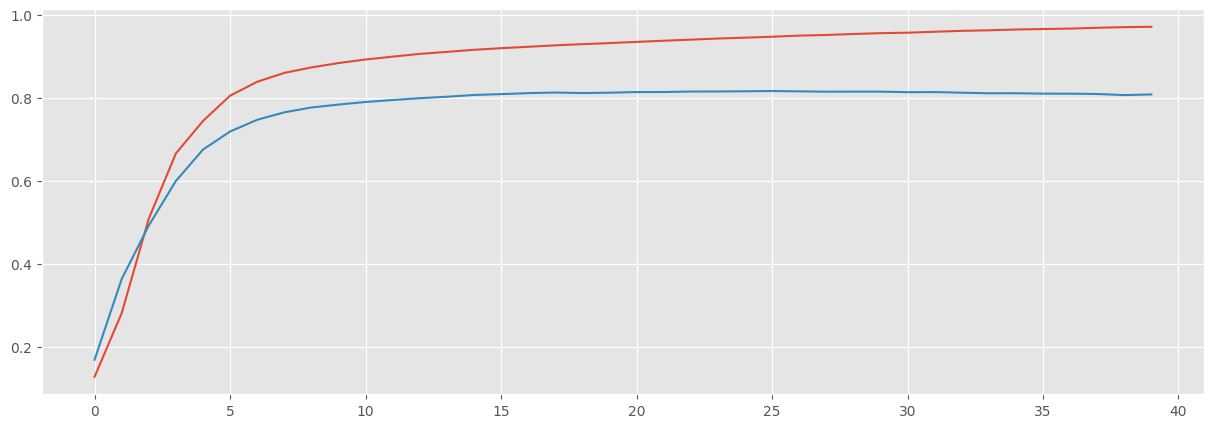

<Figure size 1500x500 with 0 Axes>

In [68]:
train_plt = plt.plot(log['train_accuracy'], label="Train")
test_plt = plt.plot(log['test_accuracy'], label="Test")
plt.figure()

### Will we always be better with more epochs?
No, after some time we reach the state of over fitting in witch the models becomes excelent at identifying train data but will not keep impoving on un seen data witch is test data.
as seen in the plot above after about 10 epochs the test accuracy will make very little improvement but the train acc will go upto 97 persent. In this case we say over fitting has occurred and the model hase become less general.<br>
### What can we do to improve it?
We can detect and stop the model from overfitting witch will decrease time of training and save resources.